In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%config IPCompleter.greedy=True

In [2]:
from matplotlib import font_manager
font_manager.get_font_names()

['Gadugi',
 'cmr10',
 'cmmi10',
 'Wide Latin',
 'Parchment',
 'Tempus Sans ITC',
 'Sitka',
 'Trebuchet MS',
 'Copperplate Gothic Light',
 'DejaVu Serif Display',
 'Microsoft Yi Baiti',
 'Consolas',
 'Franklin Gothic Medium Cond',
 'Haettenschweiler',
 'Gill Sans MT Ext Condensed Bold',
 'cmss10',
 'OCR A Extended',
 'Myanmar Text',
 'SimHei',
 'Viner Hand ITC',
 'Papyrus',
 'Segoe UI Emoji',
 'HoloLens MDL2 Assets',
 'Snap ITC',
 'Berlin Sans FB',
 'Harrington',
 'Leelawadee UI',
 'Gill Sans Ultra Bold Condensed',
 'Book Antiqua',
 'Verdana',
 'Century Gothic',
 'Goudy Old Style',
 'Meiryo',
 'Niagara Solid',
 'Arial',
 'Script MT Bold',
 'Stencil',
 'Cooper Black',
 'Bahnschrift',
 'Palace Script MT',
 'Bodoni MT',
 'Franklin Gothic Medium',
 'MT Extra',
 'Mistral',
 'STIXSizeFourSym',
 'STIXGeneral',
 'Impact',
 'Vivaldi',
 'Calibri',
 'Microsoft New Tai Lue',
 'Castellar',
 'Gigi',
 'Lucida Sans Unicode',
 'Javanese Text',
 'Poor Richard',
 'Lucida Console',
 'BIZ UDGothic',
 'Leela

# The purpose of this study is to understand how my training since April has been going. 

In [3]:
original = pd.read_csv('../Data/activities.csv')
original.columns = original.columns.str.lower().str.replace(' ','_')
original = original[original['activity_type'] == 'Run']
df = original.copy(deep=True)

In [4]:
df.head()

,activity_id,activity_date,activity_name,activity_type,activity_description,elapsed_time,distance,max_heart_rate,relative_effort,commute,...,activity_count,total_steps,carbon_saved,pool_length,training_load,intensity,average_grade_adjusted_pace,timer_time,total_cycles,media
0,676696158,"Aug 15, 2016, 9:53:13 AM",Afternoon Run,Run,NaN,1414,3.31,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,681425706,"Aug 19, 2016, 10:11:34 AM",Evening Run,Run,NaN,2062,4.45,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,683559635,"Aug 21, 2016, 10:14:46 AM",Evening Run,Run,NaN,1903,4.41,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,689475888,"Aug 26, 2016, 10:22:15 AM",Evening Run,Run,NaN,1920,4.51,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,708051143,"Sep 11, 2016, 9:19:10 AM",Afternoon Run,Run,NaN,1922,4.43,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 253
Data columns (total 94 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   activity_id                   217 non-null    int64  
 1   activity_date                 217 non-null    object 
 2   activity_name                 217 non-null    object 
 3   activity_type                 217 non-null    object 
 4   activity_description          30 non-null     object 
 5   elapsed_time                  217 non-null    int64  
 6   distance                      217 non-null    float64
 7   max_heart_rate                57 non-null     float64
 8   relative_effort               57 non-null     float64
 9   commute                       217 non-null    bool   
 10  activity_private_note         0 non-null      float64
 11  activity_gear                 49 non-null     object 
 12  filename                      217 non-null    object 
 13  athlete_we

In [6]:
df = df.dropna(axis=1,how='all')

In [7]:
df = df[df.activity_type == 'Run'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 253
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   activity_id                  217 non-null    int64  
 1   activity_date                217 non-null    object 
 2   activity_name                217 non-null    object 
 3   activity_type                217 non-null    object 
 4   activity_description         30 non-null     object 
 5   elapsed_time                 217 non-null    int64  
 6   distance                     217 non-null    float64
 7   max_heart_rate               57 non-null     float64
 8   relative_effort              57 non-null     float64
 9   commute                      217 non-null    bool   
 10  activity_gear                49 non-null     object 
 11  filename                     217 non-null    object 
 12  athlete_weight               125 non-null    float64
 13  elapsed_time.1           

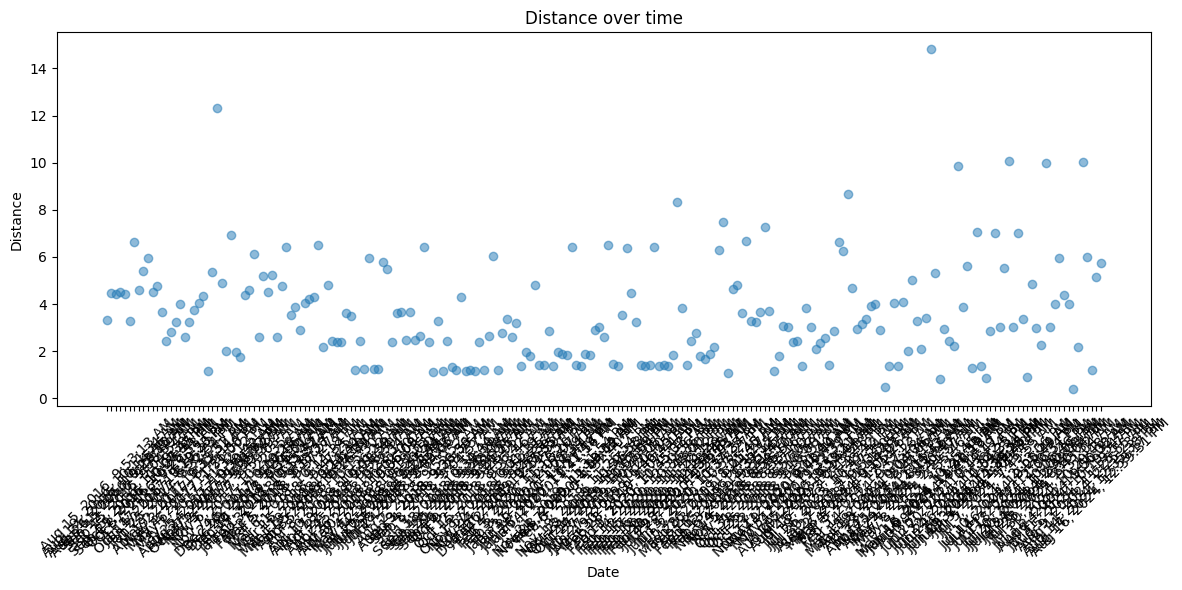

In [8]:
plt.figure(figsize=(12,6))
plt.scatter(df.activity_date,df.distance,alpha=0.5)
plt.title('Distance over time')
plt.xlabel('Date')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

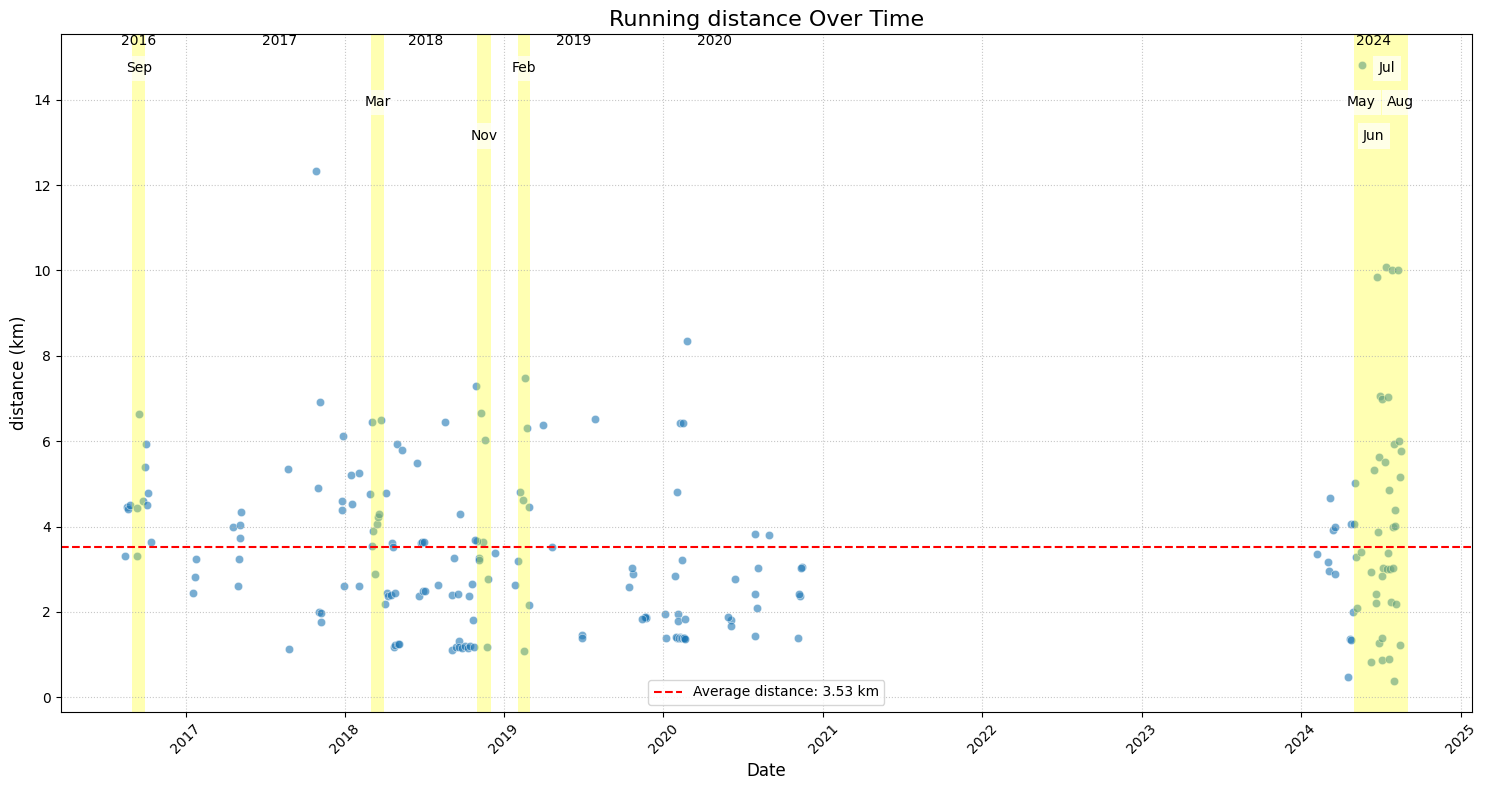

In [9]:

# Convert 'activity_date' to datetime
df['activity_date'] = pd.to_datetime(df['activity_date'])

# Filter out years 2021-2023
df = df[(df['activity_date'].dt.year < 2021) | (df['activity_date'].dt.year >= 2024)]

# Calculate average running distance
avg_distance = df['distance'].mean()

# Create the plot
plt.figure(figsize=(15, 8))

# Scatter plot of distances
sns.scatterplot(x='activity_date', y='distance', data=df, alpha=0.6)

# Add average distance line
plt.axhline(y=avg_distance, color='r', linestyle='--', label=f'Average distance: {avg_distance:.2f} km')

# Customize the plot
plt.title('Running distance Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('distance (km)', fontsize=12)
plt.legend(fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add text annotations for years
for year in df['activity_date'].dt.year.unique():
    plt.text(df[df['activity_date'].dt.year == year]['activity_date'].mean(), 
             plt.ylim()[1], str(year), 
             horizontalalignment='center', verticalalignment='top')

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Identify hotspots (periods with high frequency and/or distance)
df['Month'] = df['activity_date'].dt.to_period('M')
monthly_stats = df.groupby('Month').agg({'distance': ['count', 'mean']})
monthly_stats.columns = ['Count', 'Avg_distance']
hotspots = monthly_stats[(monthly_stats['Count'] > monthly_stats['Count'].mean()) & 
                         (monthly_stats['Avg_distance'] > monthly_stats['Avg_distance'].mean())]

# Highlight hotspots and add labels
for i, (date, stats) in enumerate(hotspots.iterrows()):
    span = plt.axvspan(date.start_time, date.end_time, facecolor='yellow', alpha=0.3)
    
    # Add text label for each hotspot
    label_y = plt.ylim()[1] - (i % 3 + 1) * (plt.ylim()[1] - plt.ylim()[0]) / 20  # Stagger labels vertically
    plt.text(date.start_time + (date.end_time - date.start_time)/2, label_y,
             date.strftime('%b'),
             horizontalalignment='center', verticalalignment='center',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.tight_layout()
plt.show()

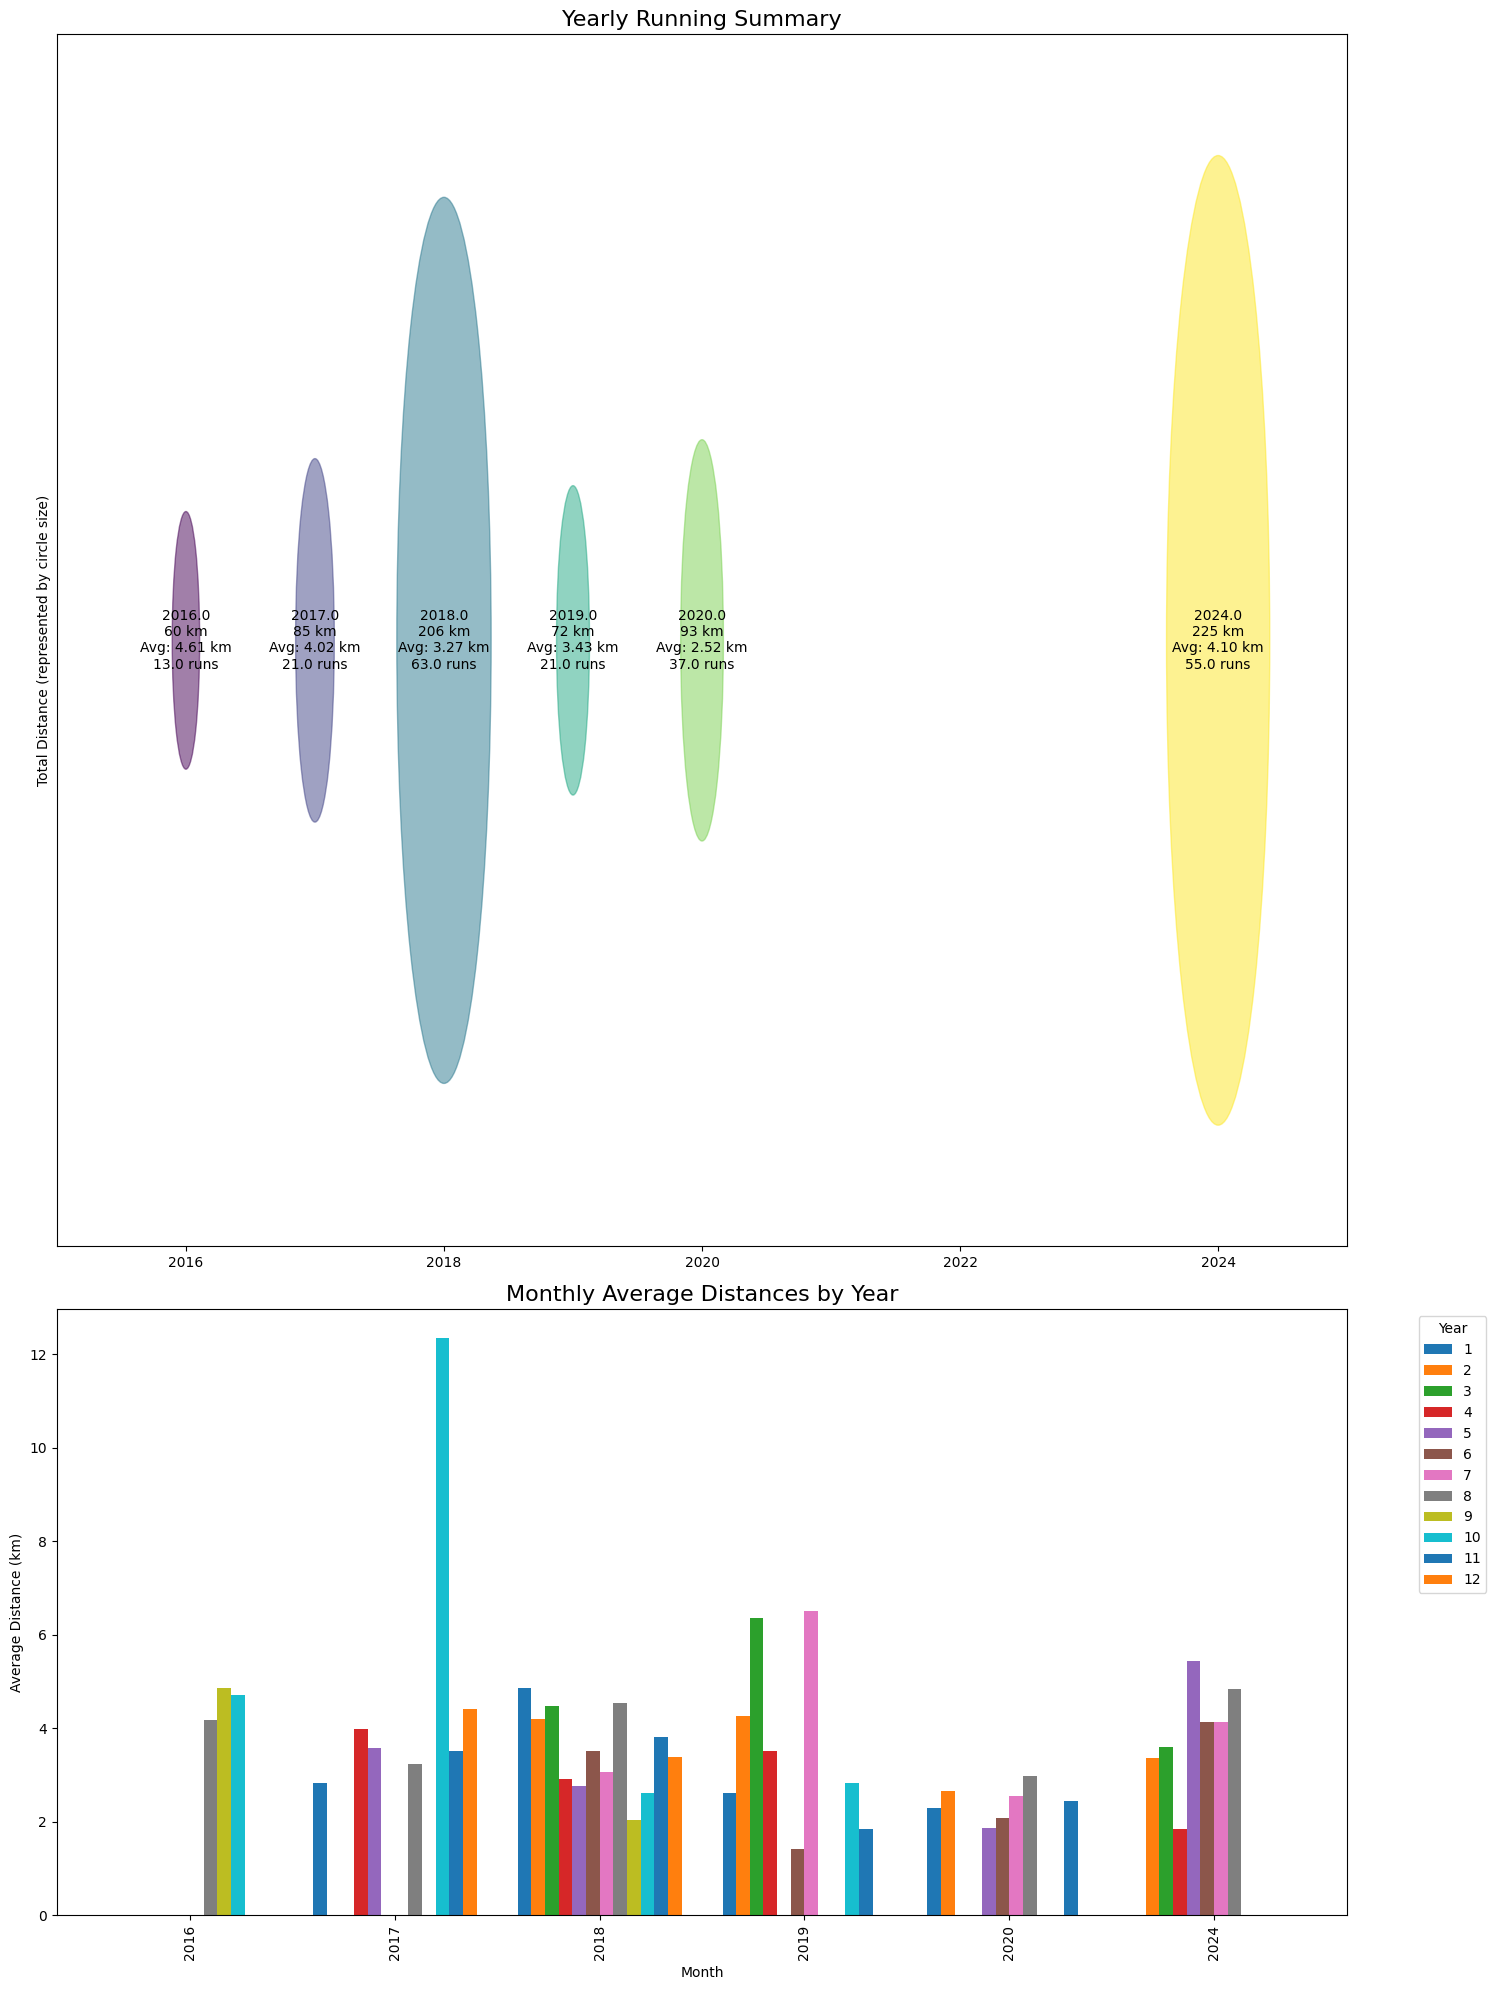

In [10]:
import calendar 

# Create year and month columns
df['year'] = df['activity_date'].dt.year
df['month'] = df['activity_date'].dt.month

# Calculate yearly totals and averages
yearly_stats = df.groupby('year').agg({
    'distance': ['sum', 'mean', 'count']
}).reset_index()
yearly_stats.columns = ['year', 'total_distance', 'avg_distance', 'run_count']

# Calculate monthly averages for each year
monthly_avg = df.groupby(['year', 'month'])['distance'].mean().unstack()

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20), gridspec_kw={'height_ratios': [2, 1]})

# Circle plot for yearly totals
max_total = yearly_stats['total_distance'].max()
colors = plt.cm.viridis(np.linspace(0, 1, len(yearly_stats)))
for i, (_, row) in enumerate(yearly_stats.iterrows()):
    circle = plt.Circle((row['year'], 0), row['total_distance']/max_total*0.4, 
                        alpha=0.5, color=colors[i])
    ax1.add_artist(circle)
    ax1.annotate(f"{row['year']}\n{row['total_distance']:.0f} km\nAvg: {row['avg_distance']:.2f} km\n{row['run_count']} runs", 
                 (row['year'], 0), ha='center', va='center')

ax1.set_xlim(yearly_stats['year'].min() - 1, yearly_stats['year'].max() + 1)
ax1.set_ylim(-0.5, 0.5)
ax1.set_title('Yearly Running Summary', fontsize=16)
ax1.set_ylabel('Total Distance (represented by circle size)')
ax1.set_yticks([])

# Bar plot for monthly averages
monthly_avg.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Distance (km)')
ax2.set_title('Monthly Average Distances by Year', fontsize=16)
ax2.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
# ax2.set_xticks(range(12))
present_months = monthly_avg.columns  # Assuming these are the month numbers
# ax2.set_xticklabels([calendar.month_abbr[i] for i in present_months], rotation=0)

plt.tight_layout()
plt.show()

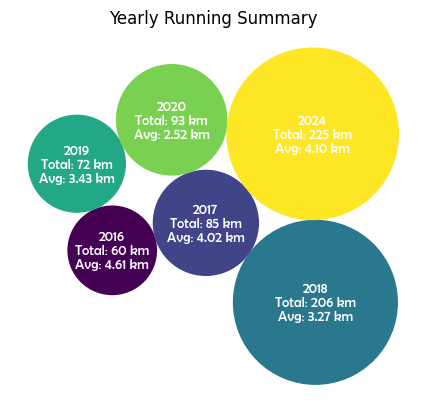

In [11]:
# Assuming df is your DataFrame with the running data
# and you've already calculated yearly_stats as before

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)
        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]
        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3])

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0], bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                dir_vec = self.com - self.bubbles[i, :2]
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        new_point1 = self.bubbles[i, :2] + orth * self.step_dist
                        new_point2 = self.bubbles[i, :2] - orth * self.step_dist
                        dist1 = self.center_distance(self.com, np.array([new_point1]))
                        dist2 = self.center_distance(self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()
            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors,font_color):
        for i in range(len(self.bubbles)):
            circ = plt.Circle(self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center',color=font_color,fontname='Berlin Sans FB',size='medium',fontweight='roman')

# Prepare data for bubble chart
num_years = len(yearly_stats)
colors = plt.cm.viridis(np.linspace(0, 1, num_years))
yearly_stats['color'] = colors.tolist()  # Convert numpy array to list
bubble_chart = BubbleChart(area=yearly_stats['total_distance'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
labels = [f"{year}\nTotal: {total:.0f} km\nAvg: {avg:.2f} km" 
          for year, total, avg in zip(yearly_stats['year'], 
                                      yearly_stats['total_distance'], 
                                      yearly_stats['avg_distance'])]
bubble_chart.plot(ax, labels, yearly_stats['color'],'white')
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Yearly Running Summary')

plt.show()

### Now I want to remove any unnecessary columns, then lets turn that into a function. So maybe I could turn this into a useful running program?

In [12]:
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts>0]
null_columns

activity_description           180
max_heart_rate                 156
relative_effort                156
activity_gear                  161
athlete_weight                  85
average_speed                   90
elevation_loss                 100
max_heart_rate.1               163
average_heart_rate             156
relative_effort.1              156
perceived_exertion             208
prefer_perceived_exertion      178
perceived_relative_effort      208
from_upload                     90
grade_adjusted_distance         62
weather_observation_time       185
weather_condition              185
weather_temperature            185
apparent_temperature           185
dewpoint                       185
humidity                       185
weather_pressure               185
wind_speed                     185
wind_gust                      185
wind_bearing                   185
precipitation_intensity        185
sunrise_time                   185
sunset_time                    185
moon_phase          

### I've decided that choosing the columns I want to keep is a better approach

In [13]:
columns_keep = ['activity_date','elapsed_time','distance','max_speed','average_speed','elevation_gain','elevation_loss','elevation_low','elevation_high','max_grade','average_grade','max_heart_rate','average_heart_rate','total_steps']
df = df.loc[:,columns_keep]
df.head()

,activity_date,elapsed_time,distance,max_speed,average_speed,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,average_heart_rate,total_steps
0,2016-08-15 09:53:13,1414,3.31,7.2,NaN,39.465000,NaN,53.200001,87.599998,16.200001,-0.241473,NaN,NaN,NaN
1,2016-08-19 10:11:34,2062,4.45,8.3,NaN,63.403999,NaN,50.299999,87.300003,40.200001,0.125682,NaN,NaN,NaN
2,2016-08-21 10:14:46,1903,4.41,5.5,NaN,51.626202,NaN,46.400002,87.699997,16.299999,-0.002268,NaN,NaN,NaN
3,2016-08-26 10:22:15,1920,4.51,5.7,NaN,119.328003,NaN,64.000000,137.699997,22.400000,0.026587,NaN,NaN,NaN
4,2016-09-11 09:19:10,1922,4.43,4.9,NaN,130.173996,NaN,64.000000,138.300003,23.500000,0.069921,NaN,NaN,NaN


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 0 to 253
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity_date       210 non-null    datetime64[ns]
 1   elapsed_time        210 non-null    int64         
 2   distance            210 non-null    float64       
 3   max_speed           210 non-null    float64       
 4   average_speed       120 non-null    float64       
 5   elevation_gain      210 non-null    float64       
 6   elevation_loss      110 non-null    float64       
 7   elevation_low       210 non-null    float64       
 8   elevation_high      210 non-null    float64       
 9   max_grade           210 non-null    float64       
 10  average_grade       210 non-null    float64       
 11  max_heart_rate      54 non-null     float64       
 12  average_heart_rate  54 non-null     float64       
 13  total_steps         55 non-null     float64       
dtyp

In [15]:
df.activity_date = pd.to_datetime(df.activity_date)

# So the rest of the float values are values are acceptable
# 

In [16]:
training_begins_df = df[df.activity_date > '2024-04-01']

In [17]:
training_begins_df.isnull()

,activity_date,elapsed_time,distance,max_speed,average_speed,elevation_gain,elevation_loss,elevation_low,elevation_high,max_grade,average_grade,max_heart_rate,average_heart_rate,total_steps
187,False,False,False,False,False,False,False,False,False,False,False,False,False,False
190,False,False,False,False,False,False,False,False,False,False,False,False,False,False
193,False,False,False,False,False,False,False,False,False,False,False,False,False,False
194,False,False,False,False,False,False,False,False,False,False,False,False,False,False
195,False,False,False,False,False,False,False,False,False,False,False,False,False,False
196,False,False,False,False,False,False,False,False,False,False,False,False,False,False
199,False,False,False,False,False,False,False,False,False,False,False,False,False,False
200,False,False,False,False,False,False,False,False,False,False,False,False,False,False
201,False,False,False,False,False,False,False,False,False,False,False,False,False,False
202,False,False,False,False,False,False,False,False,False,False,False,False,False,False
